#  Stacking for the estimation of Treatment Effects

# 1. Generate data
generate data according to the same process as Nie X. and Wager S. (2018) 'Quasi-Oracle Estimation of Heterogeneous Treatment Effects'. a library is provided by `causalml` from uber (https://github.com/uber/causalml). 

the goal in simulating data : to provide different examples of data generating processes, in order to conclude upon the effectiveness of stacking for treatment effects in each situation. 

In an experimental setup, or a situation in which we have treated and untreated data, it is necessary to estimate the underlying distribution of the 'nuisance variables', the propensity score (the likelihood, given an observation's characteristics, to be treated), and the underlying treatment effect. As such, we simulate different X, propensity, and treatment functions.

`causalml` provides an implementation of each data generating function as seen in Nie & Wager, accessible through five possible modes passed to synthetic_data() :          

    `       1 for difficult nuisance components and an easy treatment effect.
            2 for a randomized trial.
            3 for an easy propensity and a difficult baseline.
            4 for unrelated treatment and control groups.
            5 for a hidden confounder biasing treatment.

!!!! talk here about how its useful to use the data generators from causal ml bc :
 - this allows us to generate as much data as we need in order to cross validate. we essentially always have a holdout set read to test.
 - we also need true treatment effects in order to set up a stacking pipeline, there is otherwise no way to estimate a stacking model without a true $\tau(X)$

In [1]:
import numpy as np
from causalml.dataset import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from mlens.ensemble import SuperLearner
from sklearn.metrics import r2_score, mean_squared_error
import simple_model_a

The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
[MLENS] backend: threading


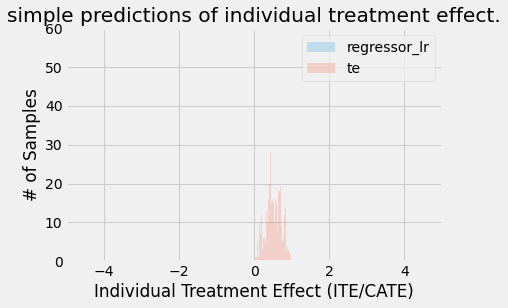

r2 score is:-0.3409142786837409
MSE is:0.05461195250679375


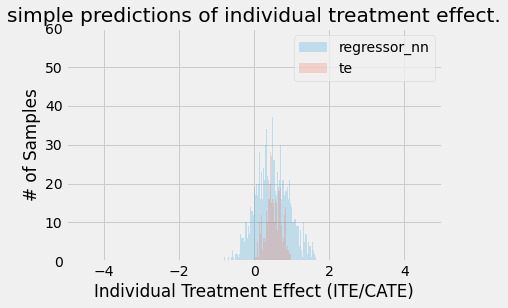

r2 score is:-1.3684592323542528
MSE is:0.0964611870928659


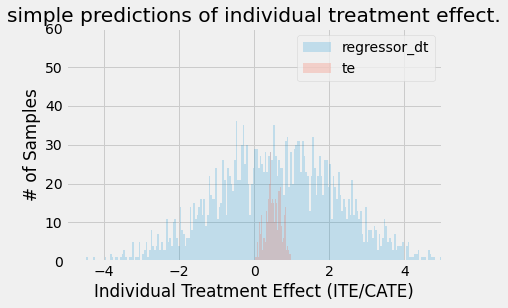

r2 score is:-60.26002713374018
MSE is:2.4949616433920974


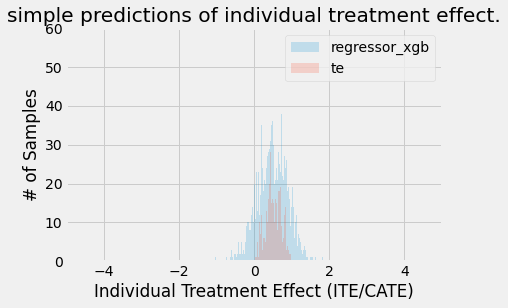

r2 score is:-1.3523661277301762
MSE is:0.09580575677984123


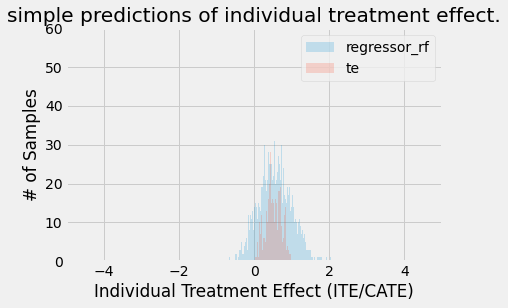

r2 score is:-1.8651063485893902
MSE is:0.1166883329705976


In [2]:
regressors = { 'regressor_lr' :LinearRegression(),
               'regressor_nn': MLPRegressor(),
               'regressor_dt' : DecisionTreeRegressor(),
               'regressor_xgb' : XGBRegressor(),
               'regressor_rf': RandomForestRegressor()}
e_regressors = regressors.copy()

np.random.seed(42)

y_easy, X_easy, w_easy, tau_easy, b_easy, e_easy = simulate_nuisance_and_easy_treatment(n=10000, p=20)

y_easy_train, y_easy_test, X_easy_train, X_easy_test, w_easy_train, w_easy_test, tau_easy_train, tau_easy_test = train_test_split(
y_easy, X_easy, w_easy, tau_easy, test_size=0.25, random_state=42)

easy_preds = simple_model_a.make_simple_predictions_for_stacking(X_easy_train, X_easy_test, y_easy_train, w_easy_train, regressors)
simple_model_a.multilayer_hist(easy_preds, tau_easy_test)

In [6]:
ensemble = SuperLearner(scorer=mean_squared_error, random_state=42)
ensemble.add([e_regressors['regressor_rf'], e_regressors['regressor_xgb'], e_regressors['regressor_nn'], e_regressors['regressor_lr']])
ensemble.add_meta(e_regressors['regressor_nn'])

SuperLearner(array_check=None, backend=None, folds=2,
       layers=[Layer(backend='threading', dtype=<class 'numpy.float32'>, n_jobs=-1,
   name='layer-1', propagate_features=None, raise_on_exception=True,
   random_state=7270, shuffle=False,
   stack=[Group(backend='threading', dtype=<class 'numpy.float32'>,
   indexer=FoldIndex(X=None, folds=2, raise_on_ex...7D53CA0>)],
   n_jobs=-1, name='group-3', raise_on_exception=True, transformers=[])],
   verbose=0)],
       model_selection=False, n_jobs=None, raise_on_exception=True,
       random_state=42, sample_size=20,
       scorer=<function mean_squared_error at 0x000002A697D53CA0>,
       shuffle=False, verbose=False)

In [7]:
e_preds = simple_model_a.create_simple_ml_model(X_easy_train, X_easy_test, y_easy_train, w_easy_train, ensemble)

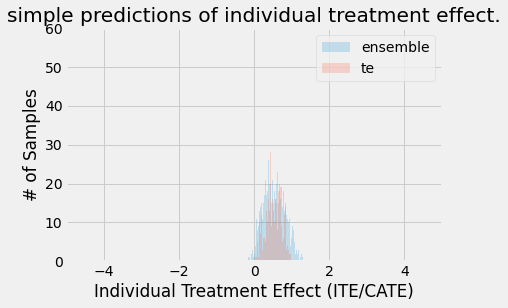

r2 score is:0.2127972669394671
MSE is:0.03206072077427669


In [8]:
simple_model_a.multilayer_hist({'ensemble':e_preds}, tau_easy_test)

In [ ]:
# import stacking_helpers
# simple_stackimg_model = stacking_helpers.do_stacking(easy_t_preds, tau_easy_t)

# stacking_helpers.plot_stacking_preds(simple_stackimg_model, tau_easy_t)

# mse_dict = stacking_helpers.evaluate_models_compare_to_stacking(easy_t_preds, tau_easy_t, simple_stackimg_model.fittedvalues)
# ##TODO: standardise the predicitons, run the model and get weights, and then try on new data to see if we get any closer to the real model
# ##also print the mse dict!

_write some text on the weights for stacking_

why we cant just use sklearn stacking if we are just treating the treatment var like a dummy var:
OR WE CAN DO STACKING IN THE CASE WHERE WE LEARN THE TREATED AND UNTREATED ARM INDEPENDENTLY. thats how we are predicting anyways.
there are a bunch of different setups/order of operations if we intend to do stacking to use the models as averages

the pipeline for stacking can take many forms when esitmating treatment effects.

also need to mention when we talk about each of the datasets : what is the best possible outcome we can expect from any model? each dataset has its data generating function with more or less randomness introduced.


so now that we have more or less a framework for the simple case of predicting treatment effects and obviously stacking does work ok
we can look at other ways to try stacking while incorporating double machine learning..

the next logical step would be to stack several t learners.
do we think this would work better?

# 2. Learner selection -

## Grimmer et al, the 'T learner' and OLS.
Nie and Wager estimate treatment effects using (among other heterogeneous treatment effect estimators) the 'T-Learner', we take this learner to be the same as that which is used in Grimmer (2017)
`causalml library also provides a T-learner as used in Grimmer (2017), where the treatment effect is estimated by simple comparison of the treated against the untreated.

The T Learner fits the functions $ \mu^*_w(x) = E(Y\mid X = x, W = w)$ separately for the treatment and the control groups (for $w \in{0, 1}$), and then esimates $\tau(x) = \mu_1(x) - \mu_0(x)$
The T learner (`BaseTRegressor()`) as implemented by `causalml` can be fed a machine learning model to estimate and predict treatment effects.
it will therefore be useful to have a stacking pipeline which includes several T-Learners, over different datasets in order to examine how well a Stacked T learner does under different data generating functions.

we can use this to stack estimates exactly as in Grimmer, and compare them to the R learners/DML learnings (also stacked) as in Nie, Wager
this would answer the questions:
 - how does stacking **without** double machine learning compare to the R learner on its own? Is there an advantage to using (the best..) R learner over simple stacking? and what kind of libraries are already available for such a pipeline?
 - how much can stacking help if we do not (can not) estimate propensity scores or distinct nuisance functions in the dataset?
 - how does stacking an R learner compare to (the best) single DML model?

the T learner does not explicitly account for propensity scores, or for the 'nuisance funciton' separate from the treatment effect.

the R learner, on the other hand:
 - R leaner, DML, etc etc.
 - The proposal from Nie and Wager for using some 'out of the box models and stacking the treatment effect estimations

The R learner can also be fed different models, and the results similarly stacked.

# 2. Feed in different models

We continue in the methodology of Nie and Wager, (QUOTE), by creating R learners using various methods to estimate the underlying functions for the X variables. 
(for the moment we will always use ElasticNetPropensityModel to estimate propensity scores.)

How many models can we feed in?

In [ ]:
from causalml.inference.meta import BaseRRegressor, BaseTRegressor
import statsmodels.api as sm
import copy
import numpy as np

In [ ]:
## can start with estimates from the T learner

learner_t_xgb = BaseTRegressor(learner=XGBRegressor())
learner_t_mlpr = BaseTRegressor(learner=MLPRegressor())
learner_t_lr = BaseTRegressor(learner=LinearRegression())

estimators = {'learner_t_xgb' : BaseTRegressor(learner=XGBRegressor()),
              'learner_t_mlpr': BaseTRegressor(learner=MLPRegressor()),
              'learner_t_lr' : BaseTRegressor(learner=LinearRegression())}

predicitons_t_models = get_synthetic_preds(simulate_nuisance_and_easy_treatment,
                                               n=50000,
                                               estimators=estimators)

In [ ]:
'''
estimators = {'learner_xgb': BaseRRegressor(learner=XGBRegressor()),
              'learner_lr': BaseRRegressor(learner=LinearRegression()),
              'learner_dtr': BaseRRegressor(learner=DecisionTreeRegressor()),
              'learner_ctr': BaseRRegressor(learner=CausalTreeRegressor()),
              'learner_knr': BaseRRegressor(learner=KNeighborsRegressor()),
              'learner_svr': BaseRRegressor(learner=SVR())}
              '''
###would be cool to find some other working learners, and to start messing with the params of each!!!!
#learner_knr = BaseRRegressor(learner=KNeighborsRegressor())
#learner_svr = BaseRRegressor(learner=SVR())
#learner_ctr = BaseRRegressor(learner=CausalTreeRegressor())
#'learner_sgd': BaseRRegressor(learner=SGDRegressor())
#learner_nnr = BaseRRegressor(learner=MLPRegressor()) ##Multi-layer Perceptron regressor

estimators = {'learner_xgb': BaseRRegressor(learner=XGBRegressor()),
              'learner_lr': BaseRRegressor(learner=LinearRegression()),
              'learner_dtr': BaseRRegressor(learner=DecisionTreeRegressor())}

predictions = get_synthetic_preds(simulate_nuisance_and_easy_treatment,
                                               n=50000,
                                               estimators=estimators)

In [ ]:
### THE STADCKING PART (AGAIN.)

y_stacking = predictions['generated_data']['tau']
pred_copy = copy.deepcopy(predictions)
pred_copy.pop('Actuals')
pred_copy.pop('generated_data')

### iterate over this better so you can add mroe models.
x_stacking = np.vstack((predictions['learner_xgb'], predictions['learner_lr'], predictions['learner_dtr'])).T

### this is using ridgeCV for the method of ols.
### grimmer require that the coefficients of the final stacking regression sum to 1.
### HOW CAN WE DO THIS IN SKLEARN WHILE STILL USING CAUSALML?

model = sm.OLS(y_stacking, x_stacking)
model2 = model.fit_regularized(alpha=0.0, L1_wt=1.0, start_params=None, profile_scale=False, refit=False)
print(model2.params)
print(sum(model2.params))

this is actually a sad shortcoming of the `causalml` library, that it is not possible to feed models directly into sklearn.ensemble models.
normally an ensemble class from sklear woudl take a dict (i think..) of models and a dataset, do the entire pipeline, and then output the model.

if we would like to imitate grimmer we would also need a solution to the problem that we currently dont have a way to contstrain the ensemble coefficients such that they must sum to 1.

In [1]:
predictions_A = get_synthetic_preds(simulate_nuisance_and_easy_treatment, n=50000)
predictions_B = get_synthetic_preds(simulate_randomized_trial, n=50000)
predictions_C = get_synthetic_preds(simulate_easy_propensity_difficult_baseline, n=50000)
predictions_E = get_synthetic_preds(simulate_hidden_confounder, n=50000)

NameError: name 'get_synthetic_preds' is not defined